#Introduction
Introduction to be modified

# Installs

# Imports
These are the libraries this notebook is going to use. if you're having difficulty with executing the notebook make sure to have all modules correctly installed in your enviroment.

In [25]:
import pandas as pd
import requests
from io import BytesIO
import numpy as np
import unicodedata
import matplotlib.pyplot as plt

# Getting Started

In [26]:
#data_url = "https://raw.githubusercontent.com/Abd-Elhakim-Arabet/TC-Analysis/main/attempt_20_01.xlsx"
#response = requests.get(data_url, verify=False)
#sheets_to_combine = ["Feuil1"]
#data = pd.read_excel(BytesIO(response.content), sheet_name=sheets_to_combine, engine='openpyxl')
#data = pd.concat(data.values(), ignore_index=True)


file_path = 'data_redhouane.xlsx'
data = pd.read_excel(file_path)

# Drop the ID column
data = data.drop(['ID'],axis=1)

print(f'Number of instances = {data.shape[0]}' )
print(f'Number of attributes = {data.shape[1]}' )
data.keys()


Number of instances = 973
Number of attributes = 24


Index(['SID', 'Sex', 'Age', 'Wilaya', 'TC Type', 'Nodule Count', ' TNM',
       'Echography', 'Cytopuncture', 'Diameter', 'Location',
       'Infected Area Count', 'ATCD', 'Family Situation', 'Discovery Method',
       'Surgery Type', 'LN Dissection', 'Post-Surgery Status', 'LN Metastasis',
       'Distant Metastasis', 'Iodine Dosage', 'Capsular Invasion',
       'Muscle Tissue Invasion', 'Vascular Embolism'],
      dtype='object')

# Initial Transformation of the Data Types

Translating column names to english from french

In [27]:
#Translate french to english
def remove_accents(text):
    return ''.join(
        char for char in unicodedata.normalize('NFD', text)
        if unicodedata.category(char) != 'Mn'
    )

data.columns = [remove_accents(col) for col in data.columns]


Convert Diametre to a float number in cm

In [28]:
def convert_to_cm(value):
    if value is np.nan:
        return None
    if "cm" in value:
        return float(value.replace(" cm", "")) 
    elif "mm" in value:
        return float(value.replace(" mm", "")) / 10
    else:
        return None 
    
data["Diameter"] = data["Diameter"].apply(convert_to_cm)

In [29]:
data.head()['Diameter']

0    NaN
1    1.5
2    1.0
3    1.4
4    2.0
Name: Diameter, dtype: float64

# Handling Missing Values

In [30]:
count_na = (data.isna()).sum()

print("Empty Cells in each column")
print(count_na)

Empty Cells in each column
SID                         1
Sex                        10
Age                        15
Wilaya                     27
TC Type                    26
Nodule Count              220
 TNM                       47
Echography                211
Cytopuncture               62
Diameter                   94
Location                   87
Infected Area Count       391
ATCD                       37
Family Situation           33
Discovery Method           51
Surgery Type               43
LN Dissection             111
Post-Surgery Status       141
LN Metastasis             108
Distant Metastasis        111
Iodine Dosage             500
Capsular Invasion         106
Muscle Tissue Invasion    107
Vascular Embolism         110
dtype: int64


*Numeric Data:*

We will handle the missing numerical data by filling empty cells with the median value of that column 

In [31]:
data["Nodule Count"] = data["Nodule Count"].fillna(data["Nodule Count"].median())
data["Diameter"] = data["Diameter"].fillna(data["Diameter"].median())
data["Age"] = data["Age"].fillna(data["Age"].median())

*Categorical Data:*

To be handeled later, currently left as NaN

In [32]:
#To Do

# Outliers
Outliers are data instances with characteristics that are considerably different from the rest of the dataset. 

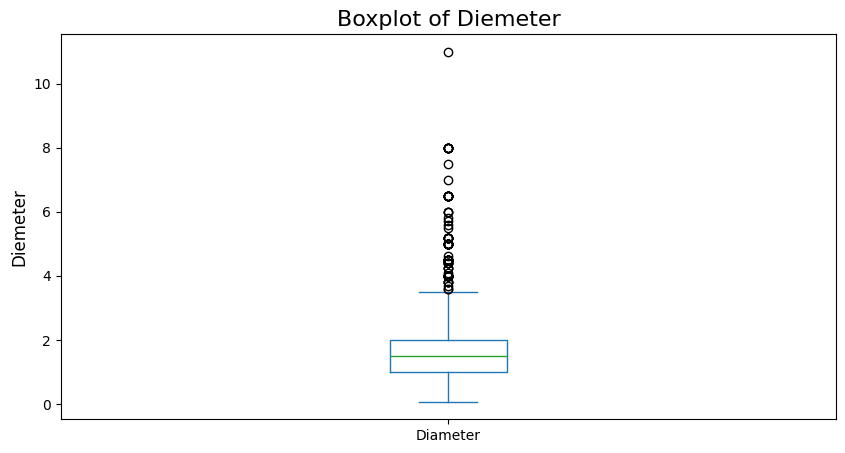

In [33]:
plt.figure(figsize=(10, 5))  
data['Diameter'].plot(kind='box', figsize=(10, 5))

plt.title("Boxplot of Diemeter", fontsize=16)
plt.ylabel("Diemeter", fontsize=12)

plt.show()

The boxplots suggest that only 8 instances have abnormally high Diemeter length. To discard the outliers, we can compute the Z-score and remove those instances containing a diameter with abnormally high or low Z-score (e.g., if Z > 3 or Z <= -3).

In [34]:
Z = (data['Diameter']-data['Diameter'].mean())/data['Diameter'].std()

In [35]:
print( f'Number of rows before discarding outliers = {data.__len__()}' )

data = data[(Z <= 3) & (Z >= -3)]
print( f'Number of rows before discarding outliers = {data.__len__()}' )

Number of rows before discarding outliers = 973
Number of rows before discarding outliers = 951


# Duplicates


In [36]:
dups = data.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))

Number of duplicate rows = 0


With no duplicates in the data, no need to handle them

ALERT: WHEN MERGING THE ENTIRE SHEETS RECHECK FOR DUPLICATES

# Unify Values Names

In [89]:
data['echographie'].value_counts()

array(['TIRADS 4', nan, 'TIRADS 3', 'TIRADS 5', 'EUTIRAD5', 'EUTIRAD6', 2,
       'TIRADS ', 'TIRADS 6', 'TIRADS 5 '], dtype=object)

We drop the values 'TIRADS' and '2' because we can't be sure what they are reffering to

In [16]:
print( f'Number of rows before droping the values = {data.__len__()}' )

data = data[data['echographie'] != 'TIRADS ']
data = data[data['echographie'] != 2]
print( f'Number of rows after droping the values = {data.__len__()}' )

Number of rows before droping the values = 403
Number of rows after droping the values = 400


We gather the mistyped classes into one and make EUTIRAD into thier TIRADS counterpart

In [17]:
data['echographie'] = data['echographie'].replace(["TIRADS 5 ", "TIRADS 5", "EUTIRAD5"], "TIRADS 5")
data['echographie'] = data['echographie'].replace(["TIRADS 6 ", "EUTIRAD6"], "TIRADS 6")

# Visualize Correlation

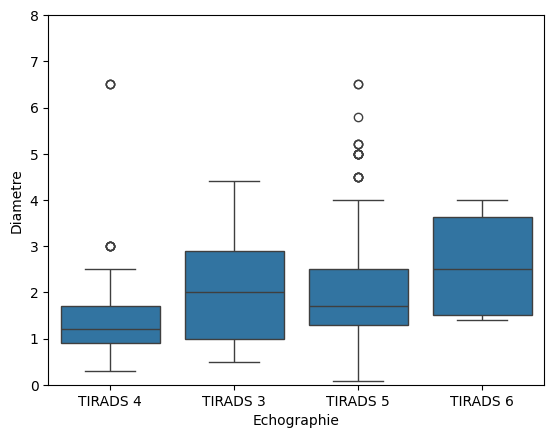

In [19]:
# Visualize relationship between price and room_type
sns.boxplot(x = 'echographie', y = 'Diametre', data = data)
plt.ylim(0, 8)
plt.xlabel('Echographie')
plt.ylabel('Diametre')
plt.show() 

# Clustering